In [1]:
import os 
import tempfile
root_dir = tempfile.mkdtemp()
print(root_dir)
data_root_dir = os.path.join(root_dir, "data")
os.makedirs(data_root_dir)

/var/tmp/tmpml33ds12


In [2]:
!pip install nibabel

In [3]:
!gsutil -m cp -r "gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs" {data_root_dir}

Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_03.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_05.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_08.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_09.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_11.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_12.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_15.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_19.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlon Prostate/151/artifactFiles/imagesTs/prostate_22.nii.gz...
Copying gs://marketplace-2xim6sjc/Med Decathlo

In [4]:
import glob 
from pathlib import Path

data_root_dir = Path(data_root_dir)
img_paths = data_root_dir.rglob("*.nii.gz")

In [5]:
img_paths = [str(p) for p in img_paths]

In [6]:
from torchvision.models import resnet18
from torchvision import models, transforms
from PIL import Image 
import nibabel as nib 
import numpy as np 
import torch 

def load_nifti_image(img_path):
    # Load the NIfTI file
    img = nib.load(img_path)
    img_data = img.get_fdata()[..., 1]

    # Normalize the image data to be between 0 and 1
    img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))    
    
    return img_data

def preprocess_image(img_arr):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.fromarray(img_arr).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

def set_model():
    model = models.resnet18(pretrained=True)
    model.eval()

    # Remove the last fully connected layer
    modules = list(model.children())[:-1]
    model = torch.nn.Sequential(*modules)

    return model


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [11]:
model = set_model()

features = []

for p in img_paths:
    vol = load_nifti_image(p)
    vol_features = []
    for slice_idx in range(vol.shape[-1]):
        img = vol[..., slice_idx]
        img = preprocess_image(img)
        vol_features.append(model(img).squeeze().detach().cpu().numpy())
    features.append(np.mean(vol_features, axis=0)) # mean features of all slices

features = np.array(features)

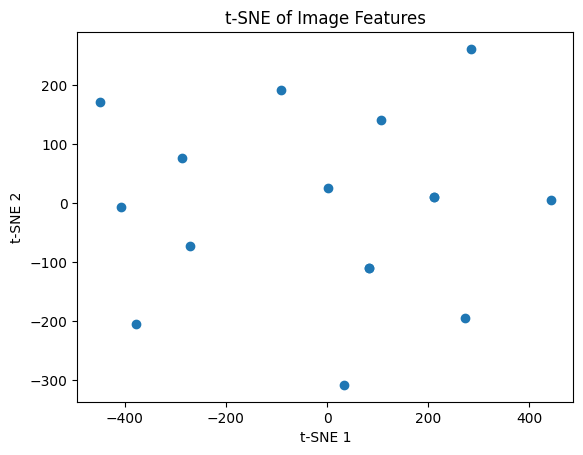

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
features_tsne = tsne.fit_transform(features)

# Plot t-SNE
plt.scatter(features_tsne[:, 0], features_tsne[:, 1])
plt.title('t-SNE of Image Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()